In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Introduction
We are interested in selecting the most appropriate ("best") variant caller for identifying SNPs and indels in microbial genomes. To do this in a principled manner, we constructed a pipeline to:
1. synthesize variants from a reference genome as our truth set for evaluating variant callers.
2. compare variant caller performance on different types of variants.


### Variant calling

In [3]:
def sum_filtered(df, filter_column, min_value, variantlog=None, logrow=2):
    '''
    df: from csv generated by testing pipeline, via checker.py
    filter_column: string of column name to filter by
    min_value: minimum threshold for values to retain when filtering by filter_column
    variantlog: variant output log generated by testing pipeline, via variants.py
    logrow: row to get total mutations from (0-start)
    '''
    sums = {}
    if filter_column == 'DP':
        filtered = df[(df[filter_column] >= min_value) | df[filter_column].isna() & (df['BAM_DP'] >= min_value)]
    else:
        filtered = df[(df[filter_column] >= min_value) | (df[filter_column].isna())]
    for tool in set(filtered['TOOL']):
        sums[tool] = [sum(filtered.loc[filtered['TOOL'] == tool, 'TRUE_POS']),
                      sum(filtered.loc[filtered['TOOL'] == tool, 'FALSE_POS']),
                      sum(filtered.loc[filtered['TOOL'] == tool, 'FALSE_NEG'])]
    filtered_sums = pd.DataFrame(data=sums).T
    filtered_sums.reset_index(inplace=True)
    filtered_sums.rename(columns={'index': 'caller', 0:'true_pos', 1:'false_pos', 2: 'false_neg'}, inplace=True)
    filtered_sums[filter_column] = min_value
    filtered_sums['recall'] = filtered_sums['true_pos'] / (filtered_sums['true_pos'] + filtered_sums['false_neg'])
    filtered_sums['precision'] = filtered_sums['true_pos'] / (filtered_sums['true_pos'] + filtered_sums['false_pos'])
    
    # Sanity check: When min_value = 0, introduced mutations == postfilter mutations
    if variantlog is not None:
        with open(variantlog, 'r') as log:
            varsettings = log.readlines()
        filtered_sums['total_mut_intro'] = int(varsettings[logrow].split(':')[-1].strip())
        filtered_sums['total_mut_postfilter'] = filtered_sums['true_pos'] + filtered_sums['false_neg']
    else:
        filtered_sums['total_mut_intro'] = np.nan
        filtered_sums['total_mut_postfilter'] = np.nan
    
    return filtered_sums

def combine_filtered(df, filter_column, filter_min, filter_max, filter_step, variantlog=None, logrow=2):
    filtered_dfs = []
    for threshold in range(filter_min, filter_max + filter_step, filter_step):
        summarydf = sum_filtered(df, filter_column, threshold, variantlog, logrow)
        filtered_dfs.append(summarydf)
    combined_summaries = pd.concat(filtered_dfs, ignore_index=True)
    return combined_summaries

In [4]:
# Called datasets
h37rv1000snp = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv10-3SNP_alltools_normalized_dp0_checked.csv')
h37rv1000ins = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv10-3INS_alltools_normalized_dp0_checked.csv')
h37rv1000del = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv10-3DEL_alltools_normalized_dp0_checked.csv')

# Filter on BAM_DP
h37rv1000snp_summary = combine_filtered(h37rv1000snp, 'BAM_DP', 0, 70, 10, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3SNP.log')
h37rv1000ins_summary = combine_filtered(h37rv1000ins, 'BAM_DP', 0, 100, 10, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3INS.log')
h37rv1000dup_summary = combine_filtered(h37rv1000ins[h37rv1000ins.INS_TYPE == 'DUP'], 'BAM_DP', 0, 100, 10, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3INS.log', 5)
h37rv1000rdm_summary = combine_filtered(h37rv1000ins[h37rv1000ins.INS_TYPE == 'RDM'], 'BAM_DP', 0, 60, 10, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3INS.log', 6)
h37rv1000inv_summary = combine_filtered(h37rv1000ins[h37rv1000ins.INS_TYPE == 'INV'], 'BAM_DP', 0, 100, 10, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3INS.log', 7)
h37rv1000del_summary = combine_filtered(h37rv1000del, 'BAM_DP', 0, 60, 10, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3DEL.log')

h37rv1000snp_summary['dataset'] = 'SNP'
h37rv1000ins_summary['dataset'] = 'INSERTION'
h37rv1000dup_summary['dataset'] = 'DUPLICATION'
h37rv1000rdm_summary['dataset'] = 'RANDOM SEQUENCE INSERTION'
h37rv1000inv_summary['dataset'] = 'INVERSION'
h37rv1000del_summary['dataset'] = 'DELETION'

In [5]:
# Filter on QUAL
h37rv1000snp_qual = combine_filtered(h37rv1000snp, 'QUAL', 0, 2400, 100, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3SNP.log')
h37rv1000ins_qual = combine_filtered(h37rv1000ins, 'QUAL', 0, 2500, 100, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3INS.log')
h37rv1000dup_qual = combine_filtered(h37rv1000ins[h37rv1000ins.INS_TYPE == 'DUP'], 'QUAL', 0, 2500, 100, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3INS.log', 5)
h37rv1000rdm_qual = combine_filtered(h37rv1000ins[h37rv1000ins.INS_TYPE == 'RDM'], 'QUAL', 0, 2400, 100, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3INS.log', 6)
h37rv1000inv_qual = combine_filtered(h37rv1000ins[h37rv1000ins.INS_TYPE == 'INV'], 'QUAL', 0, 2500, 100, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3INS.log', 7)
h37rv1000del_qual = combine_filtered(h37rv1000del, 'QUAL', 0, 2500, 100, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3DEL.log')

h37rv1000snp_qual['dataset'] = 'SNP'
h37rv1000ins_qual['dataset'] = 'INSERTION'
h37rv1000dup_qual['dataset'] = 'DUPLICATION'
h37rv1000rdm_qual['dataset'] = 'RANDOM SEQUENCE INSERTION'
h37rv1000inv_qual['dataset'] = 'INVERSION'
h37rv1000del_qual['dataset'] = 'DELETION'

In [7]:
combined_df = pd.concat([h37rv1000snp_summary, h37rv1000ins_summary, h37rv1000del_summary], ignore_index=True)
combined_df2 = pd.concat([h37rv1000snp_summary, h37rv1000dup_summary, h37rv1000rdm_summary, h37rv1000inv_summary,
                         h37rv1000del_summary], ignore_index=True)
combined_df_qual = pd.concat([h37rv1000snp_qual, h37rv1000ins_qual, h37rv1000del_qual], ignore_index=True)
combined_df2_qual = pd.concat([h37rv1000snp_qual, h37rv1000dup_qual, h37rv1000rdm_qual, 
                               h37rv1000inv_qual, h37rv1000del_qual], ignore_index=True)

#### Precision vs. Recall

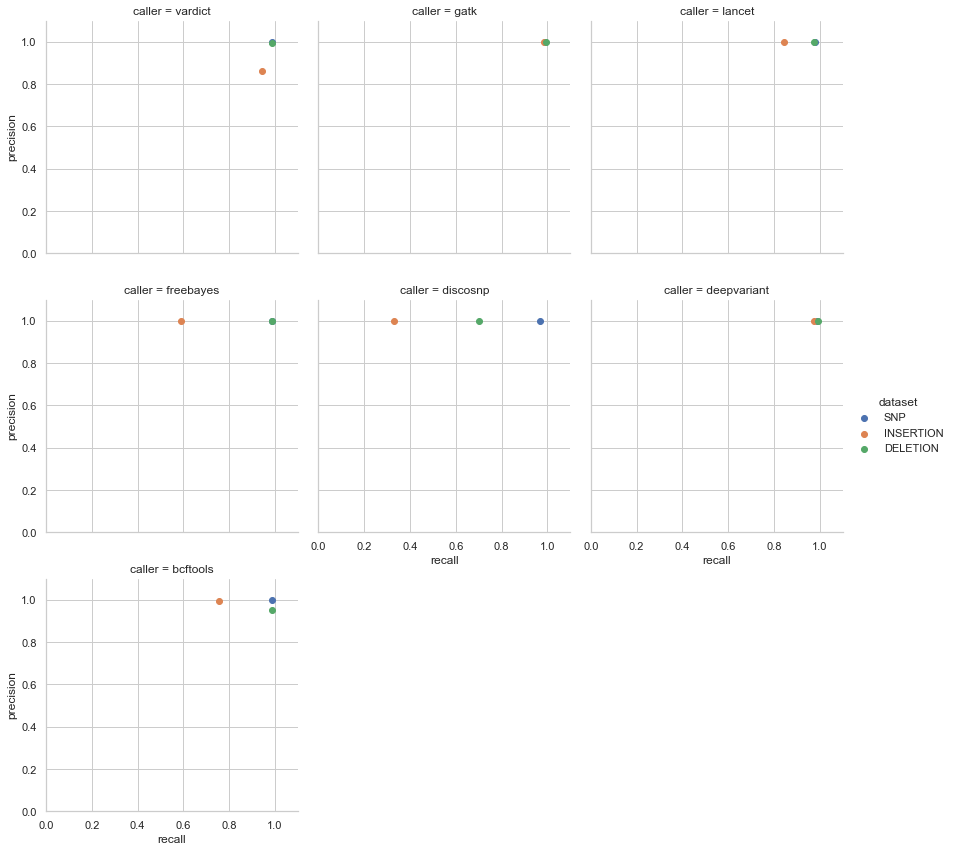

In [8]:
%matplotlib inline
sns.set(style='whitegrid')
fg = sns.FacetGrid(data=combined_df[combined_df.BAM_DP == 0], hue='dataset', 
                   height=4, aspect=1, xlim=(0,1.1), ylim=(0,1.1),
                   col='caller', col_wrap=3)
fg.map(plt.scatter, 'recall', 'precision').add_legend()

#### Effect of read depths (BAM) on recall

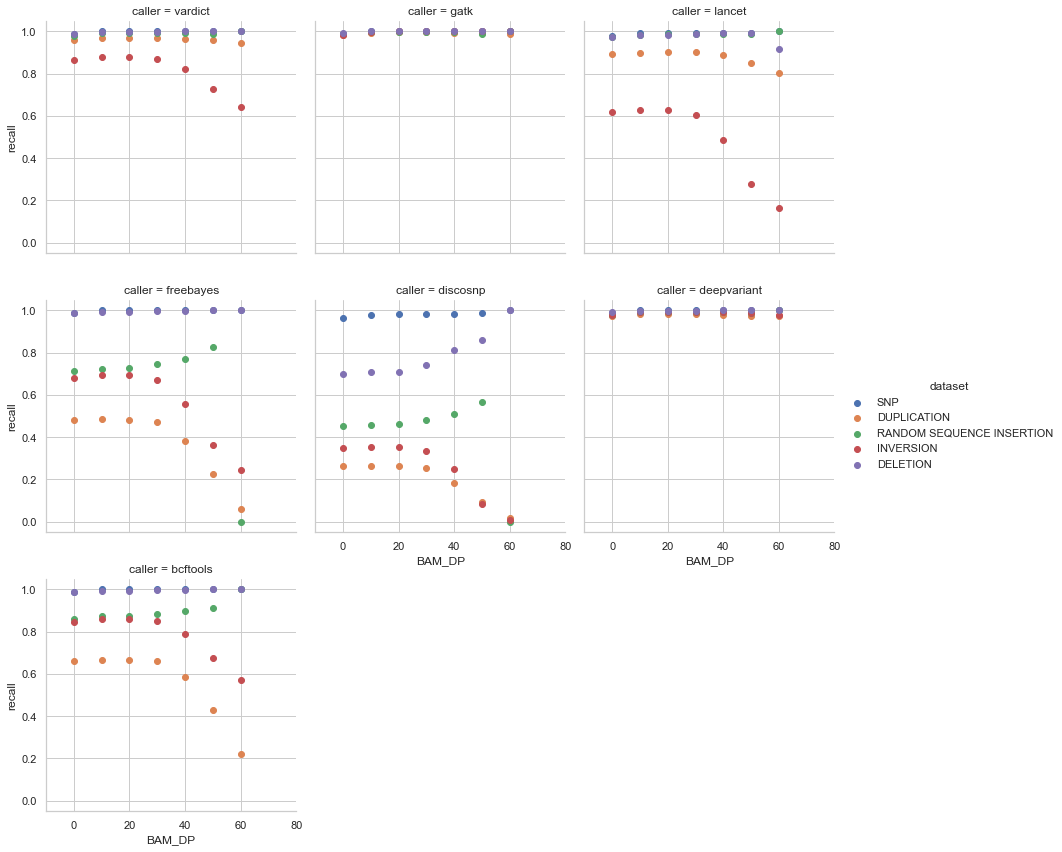

In [10]:
sns.set(style='whitegrid')
fg = sns.FacetGrid(data=combined_df2[combined_df2.BAM_DP <=60], hue='dataset', height=4, aspect=1,
                   xlim=(-10,80), col='caller', col_wrap=3, sharex=True)
fg.map(plt.scatter, 'BAM_DP', 'recall').add_legend()

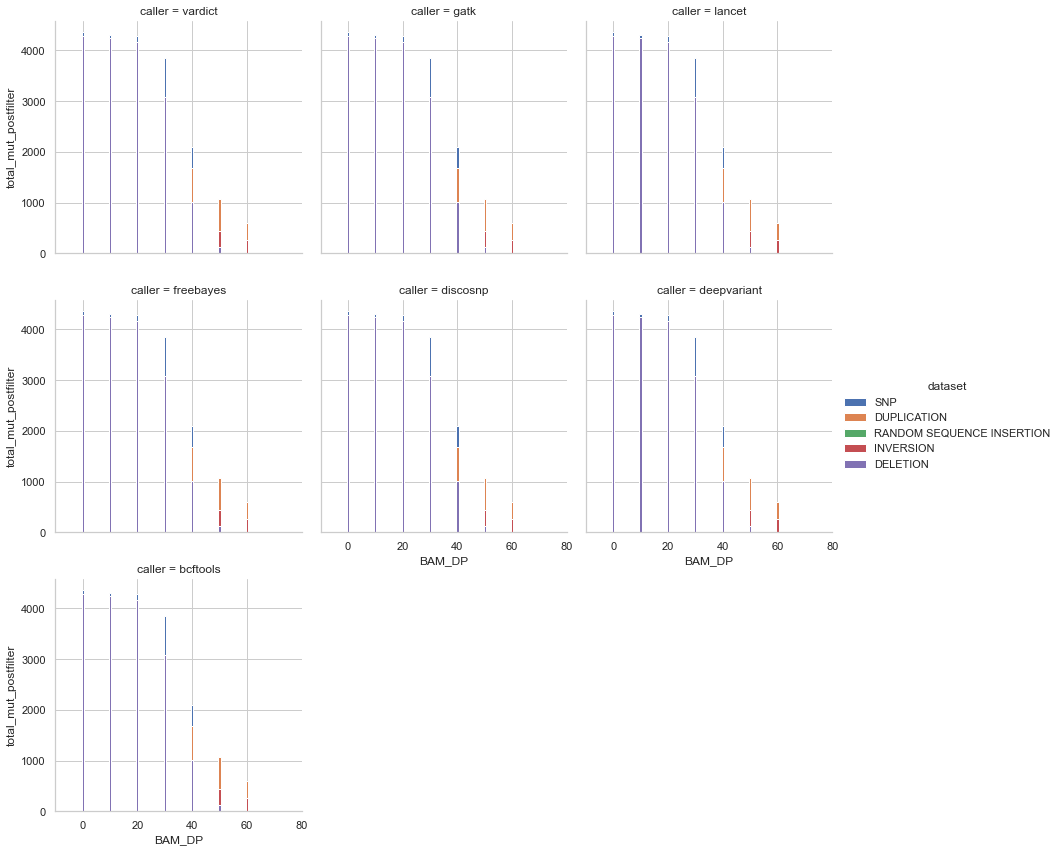

In [11]:
sns.set(style='whitegrid')
fg = sns.FacetGrid(data=combined_df2[combined_df2.BAM_DP <=60], hue='dataset', height=4, aspect=1,
                   xlim=(-10,80),
                   col='caller', col_wrap=3, sharex=True)
#fg.map(plt.scatter, 'BAM_DP', 'recall').add_legend()
fg.map(plt.bar, 'BAM_DP', 'total_mut_postfilter').add_legend()

#### Effect of read depths (BAM) on precision

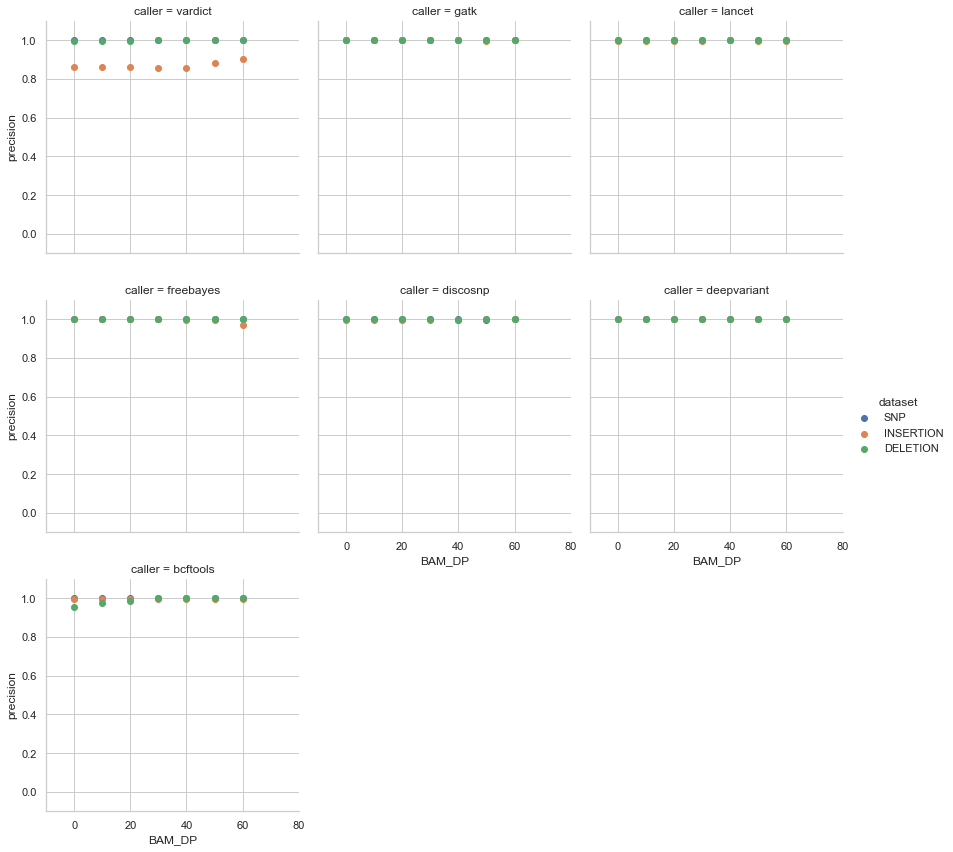

In [12]:
sns.set(style='whitegrid')
fg = sns.FacetGrid(data=combined_df[combined_df.BAM_DP <= 60], hue='dataset', height=4, aspect=1,
                   xlim=(-10,80), ylim=(-0.1,1.1),
                   col='caller', col_wrap=3)
fg.map(plt.scatter, 'BAM_DP', 'precision').add_legend()

#### Effect of QUAL filtering on recall

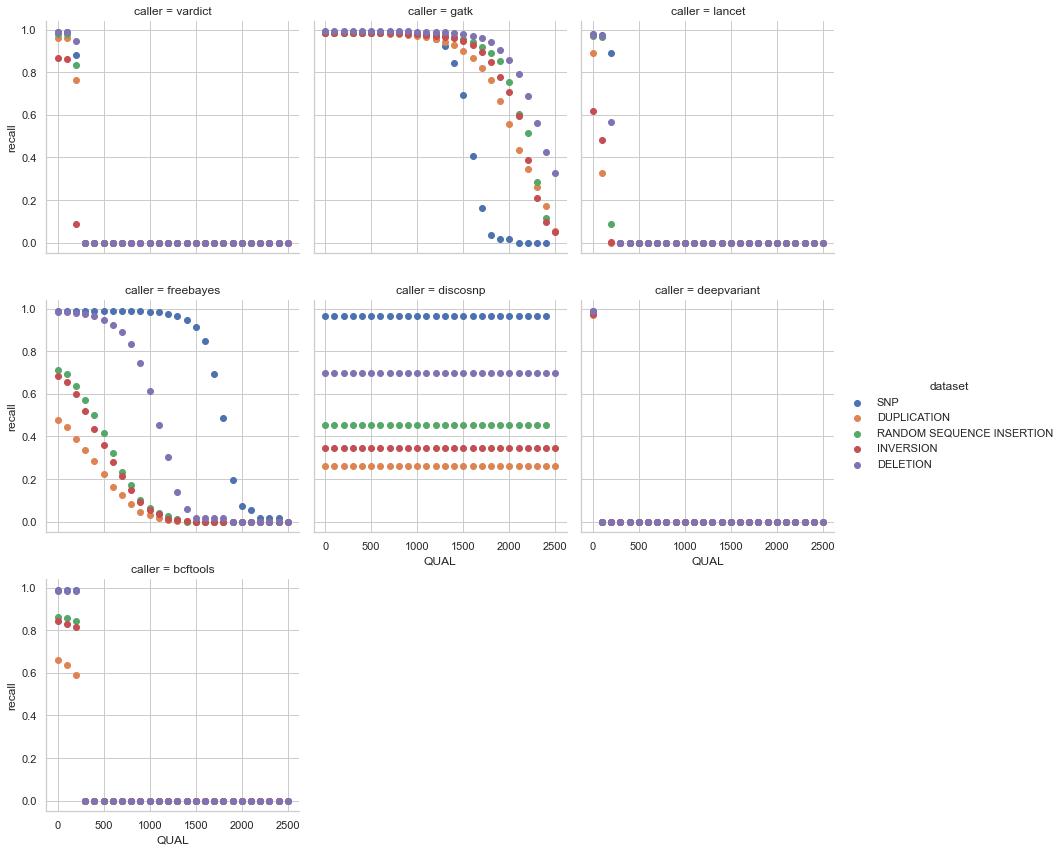

In [30]:
sns.set(style='whitegrid')
fg = sns.FacetGrid(data=combined_df2_qual, hue='dataset', height=4, aspect=1,
                   col='caller', col_wrap=3, sharex=True)
fg.map(plt.scatter, 'QUAL', 'recall').add_legend()

#### Effect of QUAL filtering on precision

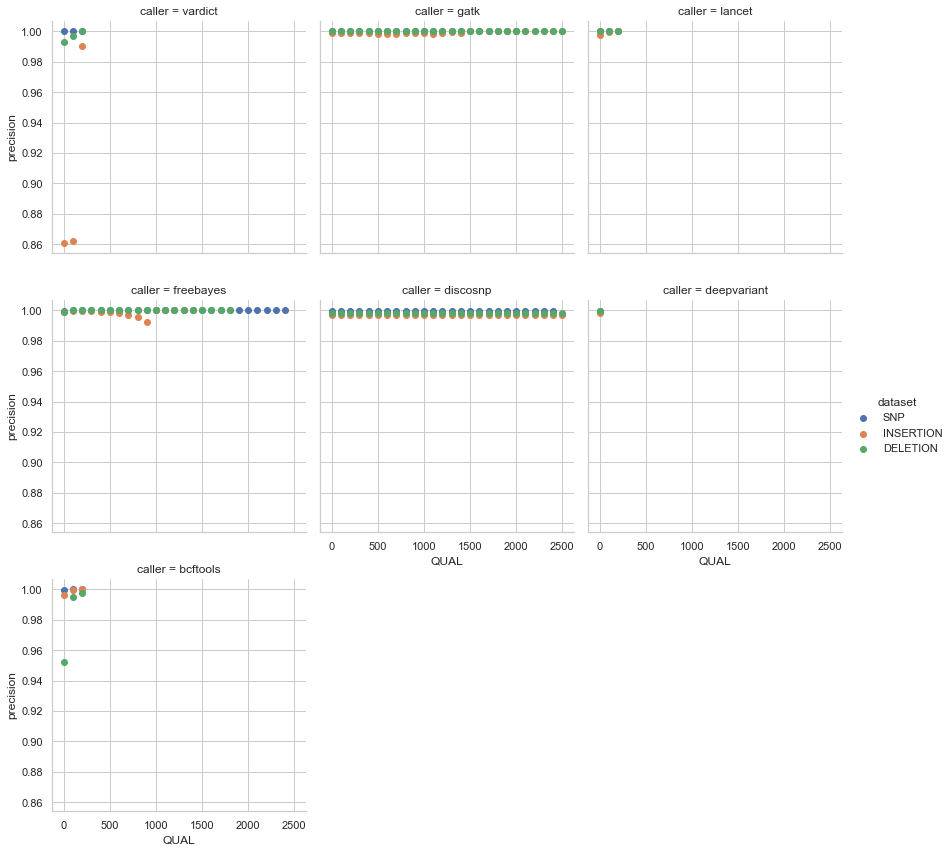

In [29]:
sns.set(style='whitegrid')
fg = sns.FacetGrid(data=combined_df_qual, hue='dataset', height=4, aspect=1,
                   col='caller', col_wrap=3, sharex=True)
fg.map(plt.scatter, 'QUAL', 'precision').add_legend()

### In-house sequenced reads (H37Ra mapped to H37Rv)

In [13]:
h37ra_toRv = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/sequenced/output/checked/sub1089-710-517_alltools_normalized_dp0_checked.csv')

In [14]:
h37ra_toRv_summary = combine_filtered(h37ra_toRv, 'BAM_DP', 0, 100, 10)

In [27]:
h37ra_toRv

,CHROM,POS,REF,ALT,TYPE,INS_TYPE,LEN,QUAL,AD_REF,AD_ALT,DP,BAM_DP,GT,ZYG,RK_DISCOSNP,TOOL,SAMPLE,TRUE_POS,FALSE_POS,FALSE_NEG
0,NC_000962.3,14785,T,C,SNP,NaN,1,2414.0,0.0,80.0,80.0,88,1,hom,NaN,gatk,sub1089-710-517,1,0,0
1,NC_000962.3,17903,G,A,SNP,NaN,1,1369.0,0.0,51.0,51.0,58,1,hom,NaN,gatk,sub1089-710-517,1,0,0
2,NC_000962.3,42417,T,C,SNP,NaN,1,1457.0,0.0,52.0,52.0,56,1,hom,NaN,gatk,sub1089-710-517,1,0,0
3,NC_000962.3,55553,C,T,SNP,NaN,1,1736.0,2.0,64.0,66.0,75,1,hom,NaN,gatk,sub1089-710-517,1,0,0
4,NC_000962.3,69989,G,A,SNP,NaN,1,2539.0,0.0,78.0,78.0,89,1,hom,NaN,gatk,sub1089-710-517,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,NC_000962.3,4095001,CG,C,INDEL,NaN,1,183.0,0.0,42.0,42.0,43,1/1,hom,NaN,vardict,sub1089-710-517,1,0,0
889,NC_000962.3,4100975,T,C,SNP,NaN,1,192.0,0.0,63.0,64.0,68,1/1,hom,NaN,vardict,sub1089-710-517,1,0,0
890,NC_000962.3,4337243,C,INV,INS,NaN,2,35.0,0.0,2.0,2.0,67,1/1,hom,NaN,vardict,sub1089-710-517,0,1,0
891,NC_000962.3,4359099,G,C,SNP,NaN,1,209.0,0.0,72.0,72.0,75,1/1,hom,NaN,vardict,sub1089-710-517,1,0,0


In [15]:
h37ra_toRv_summary

,caller,true_pos,false_pos,false_neg,BAM_DP,recall,precision,total_mut_intro,total_mut_postfilter
0,vardict,102,23,11,0,0.902655,0.816000,NaN,NaN
1,gatk,103,13,10,0,0.911504,0.887931,NaN,NaN
2,lancet,86,42,27,0,0.761062,0.671875,NaN,NaN
3,freebayes,99,10,14,0,0.876106,0.908257,NaN,NaN
4,discosnp,52,2,61,0,0.460177,0.962963,NaN,NaN
...,...,...,...,...,...,...,...,...,...
66,freebayes,2,0,0,90,1.000000,1.000000,NaN,NaN
67,discosnp,2,0,0,90,1.000000,1.000000,NaN,NaN
68,deepvariant,2,0,0,90,1.000000,1.000000,NaN,NaN
69,bcftools,2,0,0,90,1.000000,1.000000,NaN,NaN


#### Precision vs. Recall (H37Ra mapped to H37Rv)

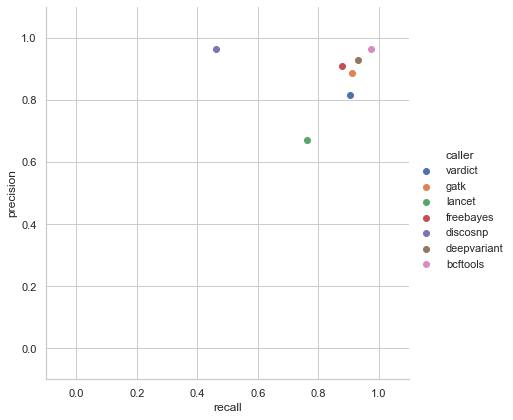

In [16]:
sns.set(style='whitegrid')
fg = sns.FacetGrid(data=h37ra_toRv_summary[h37ra_toRv_summary.BAM_DP == 0], hue='caller', 
                   height=6, aspect=1, xlim=(-0.1,1.1), ylim=(-0.1,1.1))
fg.map(plt.scatter, 'recall', 'precision').add_legend()

#### Recall, precision vs. read depth filtering (BAM_DP)

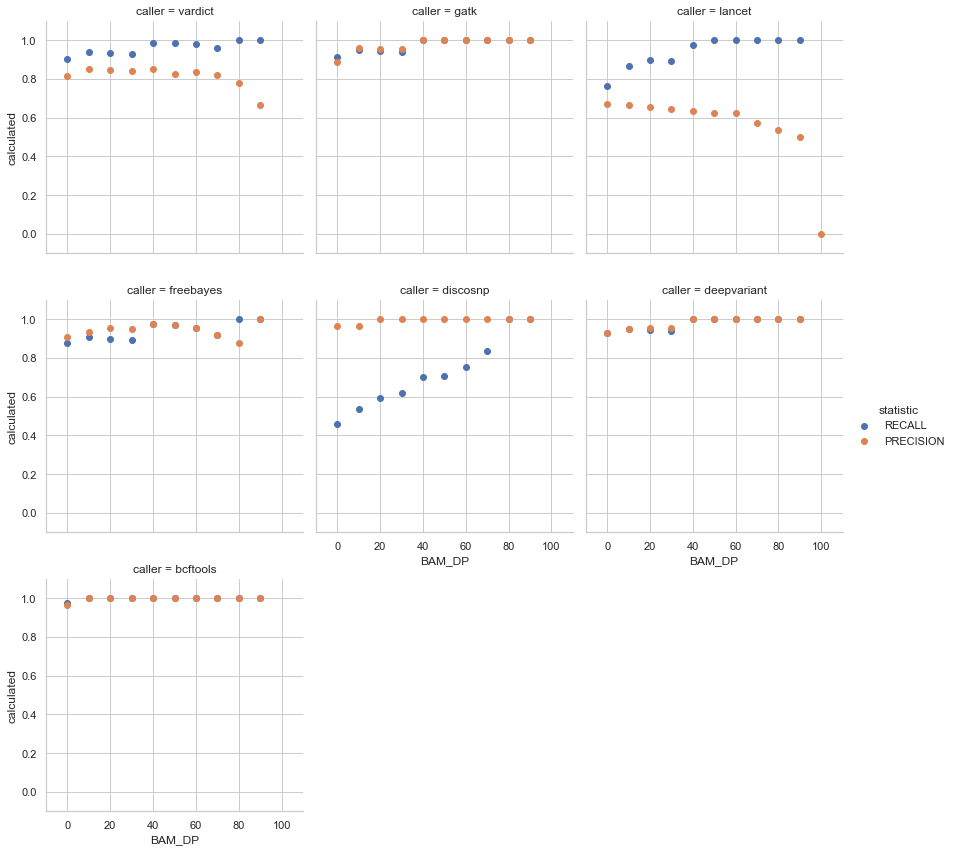

In [17]:
h37ra_toRv_recall = h37ra_toRv_summary.drop(['precision', 'total_mut_intro', 'total_mut_postfilter'], axis = 1)
h37ra_toRv_recall.rename(columns={'recall': 'calculated'}, inplace=True)
h37ra_toRv_recall['statistic'] = 'RECALL'
h37ra_toRv_precision = h37ra_toRv_summary.drop(['recall', 'total_mut_intro', 'total_mut_postfilter'], axis = 1)
h37ra_toRv_precision.rename(columns={'precision': 'calculated'}, inplace=True)
h37ra_toRv_precision['statistic'] = 'PRECISION'

h37ra_toRv_reshaped = pd.concat([h37ra_toRv_recall, h37ra_toRv_precision], ignore_index=True)

# Plot
sns.set(style='whitegrid')
fg = sns.FacetGrid(data=h37ra_toRv_reshaped, height=4, aspect=1, xlim=(-10,110), ylim=(-0.1,1.1), 
                   col='caller', col_wrap=3, hue='statistic')
fg.map(plt.scatter, 'BAM_DP', 'calculated').add_legend()

### In-house sequenced reads (H37Ra mapped to H37Ra)

In [18]:
h37ra_toRA = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/sequenced/output/checked/sub1089-710-517_alltools_normalized_dp0_H37Ra_checked.csv')

In [497]:
h37ra_toRA

,CHROM,POS,REF,ALT,TYPE,INS_TYPE,LEN,QUAL,AD_REF,AD_ALT,DP,BAM_DP,GT,ZYG,RK_DISCOSNP,TOOL,SAMPLE,TRUE_POS,FALSE_POS,FALSE_NEG
0,CP016972.1,19261,G,A,SNP,NaN,1,1369.00,0,51,51,58,1,hom,NaN,gatk,sub1089-710-517,0,1,0
1,CP016972.1,1859086,A,AG,INS,NaN,1,1595.97,2,51,53,86,1,hom,NaN,gatk,sub1089-710-517,0,1,0
2,CP016972.1,2048178,T,C,SNP,NaN,1,1374.00,0,43,43,48,1,hom,NaN,gatk,sub1089-710-517,0,1,0
3,CP016972.1,19261,G,A,SNP,NaN,1,228.28,3,39,42,58,1/1,hom,NaN,bcftools,sub1089-710-517,0,1,0
4,CP016972.1,352324,T,C,SNP,NaN,1,4.48,12,6,18,32,0/1,het,NaN,bcftools,sub1089-710-517,0,1,0
5,CP016972.1,576277,T,G,SNP,NaN,1,7.22,29,12,41,54,0/1,het,NaN,bcftools,sub1089-710-517,0,1,0
6,CP016972.1,1095237,A,G,SNP,NaN,1,5.78,6,1,7,9,0/1,het,NaN,bcftools,sub1089-710-517,0,1,0
7,CP016972.1,1240245,A,C,SNP,NaN,1,7.82,19,11,30,36,0/1,het,NaN,bcftools,sub1089-710-517,0,1,0
8,CP016972.1,1543790,C,A,SNP,NaN,1,9.00,0,1,1,1,1/1,hom,NaN,bcftools,sub1089-710-517,0,1,0
9,CP016972.1,1859086,A,AG,INS,NaN,1,228.18,14,57,71,86,1/1,hom,NaN,bcftools,sub1089-710-517,0,1,0


In [21]:
h37ra_toRA_genomecov = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/sequenced/output/variants/sub1089-710-517_deduped_mq10_genomecov.bed', sep='\t', header=None)
h37ra_toRA_genomecov.rename(columns={0:'chrom', 1:'chromStart', 2:'chromEnd', 3:'coverage'}, inplace=True)

In [24]:
# Average read depth
h37ra_toRA_genomecov.coverage.mean()

69.48792009377223

In [25]:
# Zero coverage
h37ra_toRA_genomecov[h37ra_toRA_genomecov.coverage == 0]

,chrom,chromStart,chromEnd,coverage
6013,CP016972.1,13976,14496,0
6015,CP016972.1,14646,14715,0
46013,CP016972.1,105502,105574,0
147477,CP016972.1,337126,337221,0
147810,CP016972.1,338349,338358,0
...,...,...,...,...
1699700,CP016972.1,3963665,3963791,0
1699773,CP016972.1,3964292,3964385,0
1744878,CP016972.1,4067778,4067971,0
1832863,CP016972.1,4267864,4268454,0


### Validation of variant synthesis

We use `variants.py` to introduce SNPs and/or indels at a density of 1 every 1,000 bp into the *M. tuberculosis* H37Rv reference genome (NC_000962.3).

#### Datasets

- H37Rv10-3SNP: 4364 SNPs
- H37Rv10-3IND1: 4317 indels (1119 duplications + 524 random-sequence insertion + 558 inversions + 2116 deletions)
- H37Rv10-3INS: 4401 insertions only (2204 duplications + 1089 random-sequence insertion + 1108 inversions)
- H37Rv10-3DEL: 4285 deletions only

#### Reference and variant genome alignments

mauve?

In [74]:
# Reference genome
with open('/Users/yeemayseah/Documents/Repos/mtb_amr/data/GCF_000195955.2_ASM19595v2_genomic.fna') as fa:
    ref_fa = fa.readlines()
    ref = ''
    for lines in ref_fa[1:]:
        ref += lines.rstrip()

# Variant genome
with open('/Users/yeemayseah/Documents/Repos/mtb_amr/output/variants/H37Rv10-3SNP.fa', 'r') as inputfa:
    snp1k_fa = inputfa.readlines()[1]

# Mutation list
snp1klist = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/variants/H37Rv10-3SNP.txt', sep='\t')
snp1klist.head()

,#CHROM,POS,ID,REF,ALT,TYPE,INS_TYPE
0,NC_000962.3,844,.,A,G,SNP,NaN
1,NC_000962.3,2677,.,A,G,SNP,NaN
2,NC_000962.3,4316,.,C,G,SNP,NaN
3,NC_000962.3,5666,.,G,A,SNP,NaN
4,NC_000962.3,6403,.,T,C,SNP,NaN


In [71]:
print(ref[843], ref[2676], ref[4315], ref[5665], ref[6402])
print(snp1k_fa[843], snp1k_fa[2676], snp1k_fa[4315], snp1k_fa[5665], snp1k_fa[6402])

A A C G T
G G G A C


In [70]:
snp1klist.tail()

,#CHROM,POS,ID,REF,ALT,TYPE,INS_TYPE
4359,NC_000962.3,4405635,.,C,G,SNP,NaN
4360,NC_000962.3,4406429,.,A,C,SNP,NaN
4361,NC_000962.3,4408076,.,T,C,SNP,NaN
4362,NC_000962.3,4409506,.,G,T,SNP,NaN
4363,NC_000962.3,4410737,.,C,A,SNP,NaN


In [73]:
print(ref[4405634], ref[4406428], ref[4408075], ref[4409505], ref[4410736])
print(snp1k_fa[4405634], snp1k_fa[4406428], snp1k_fa[4408075], snp1k_fa[4409505], snp1k_fa[4410736])

C A T G C
G C C T A


##### Synthetic Reads

ART was used to simulate reads based on the reference and variant genomes, with the following parameters:

In [79]:
# Distribution of simulated read lengths per dataset

### Read Mapping and Depths
Reads with MAPQ < 10 are removed.

In [117]:
# Read depth across genomes
snp1k_perbase_cov = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/mapped/H37Rv10-3SNP_trimmed-sorted_perbase-genomecov.txt', sep='\t', header=None)
ind1k_perbase_cov = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/mapped/H37Rv10-3IND1_trimmed-sorted_perbase-genomecov.txt', sep='\t', header=None)
ins1k_perbase_cov = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/mapped/H37Rv10-3INS_trimmed-sorted_perbase-genomecov.txt', sep='\t', header=None)
del1k_perbase_cov = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/mapped/H37Rv10-3DEL_trimmed-sorted_perbase-genomecov.txt', sep='\t', header=None)

In [118]:
snp1k_perbase_cov.rename(columns={1:'pos', 2:'depth'}, inplace=True)
ind1k_perbase_cov.rename(columns={1:'pos', 2:'depth'}, inplace=True)
ins1k_perbase_cov.rename(columns={1:'pos', 2:'depth'}, inplace=True)
del1k_perbase_cov.rename(columns={1:'pos', 2:'depth'}, inplace=True)

<AxesSubplot:xlabel='pos'>

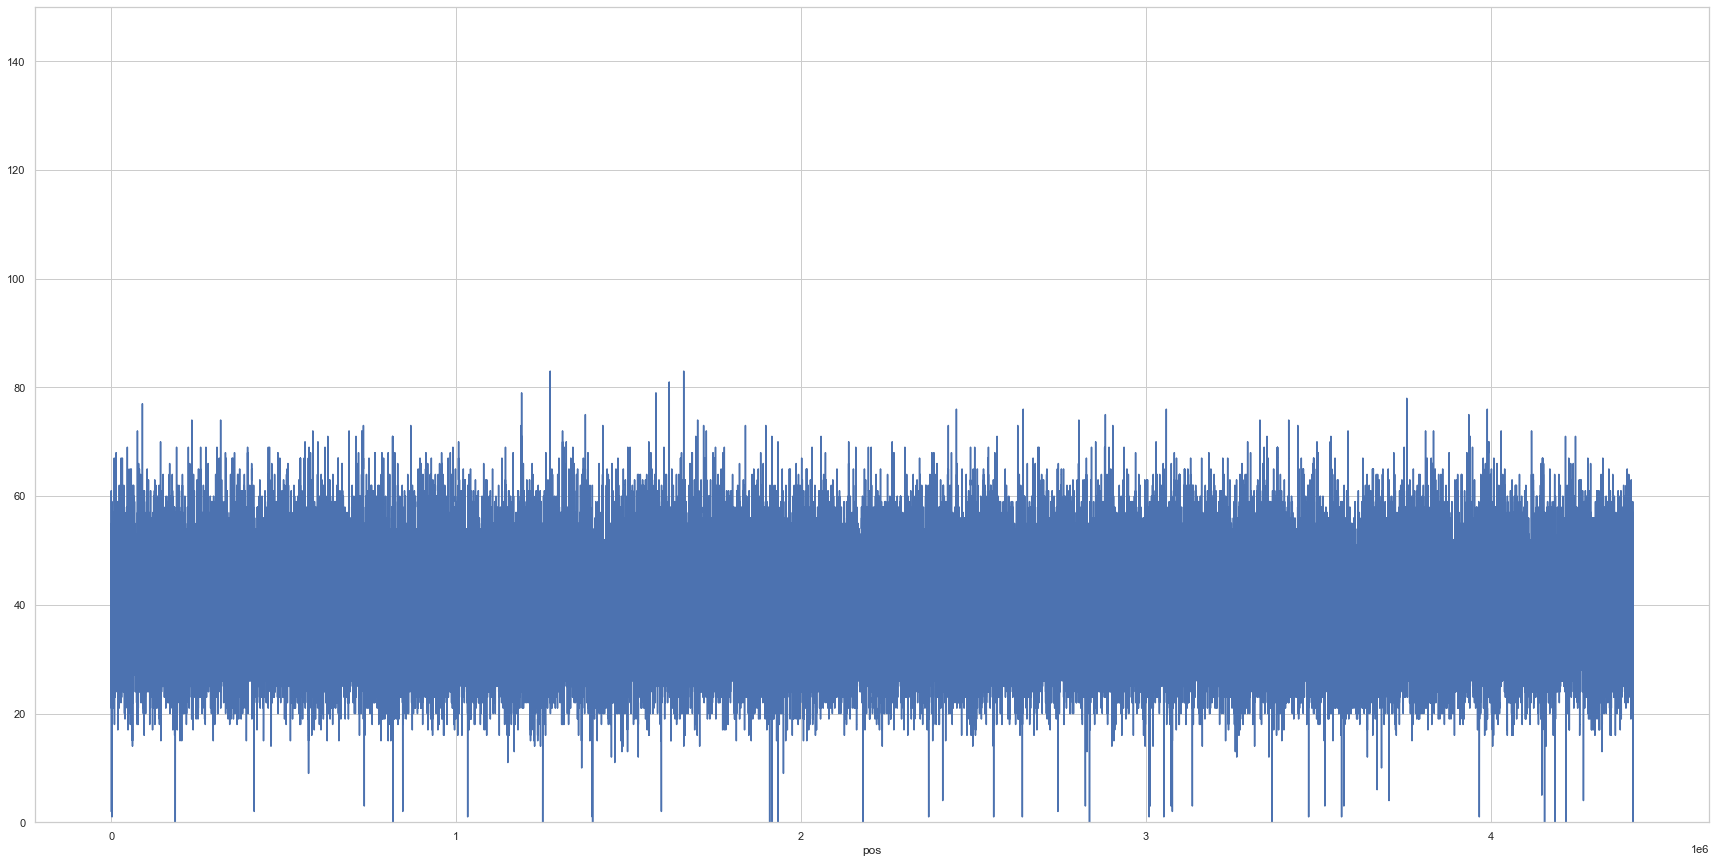

In [145]:
snp1k_perbase_cov.plot(x='pos', y='depth', kind='line', legend=False, figsize=(30,15), ylim=(0,150))

<AxesSubplot:xlabel='pos'>

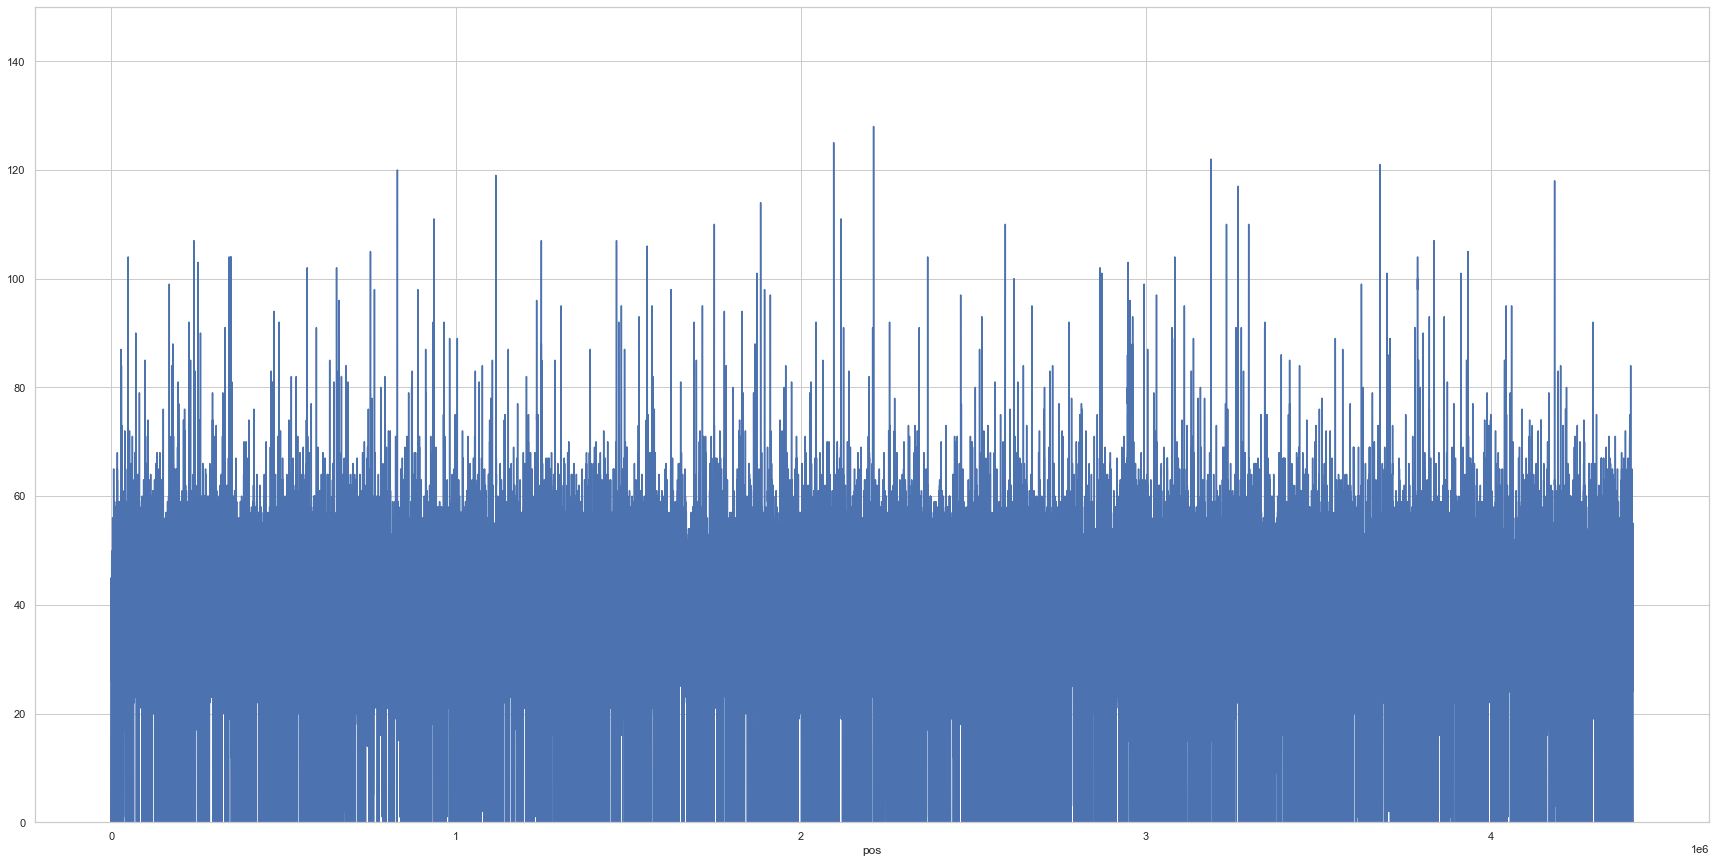

In [144]:
ind1k_perbase_cov.plot(x='pos', y='depth', kind='line', legend=False, figsize=(30,15), ylim=(0,150))

<AxesSubplot:xlabel='pos'>

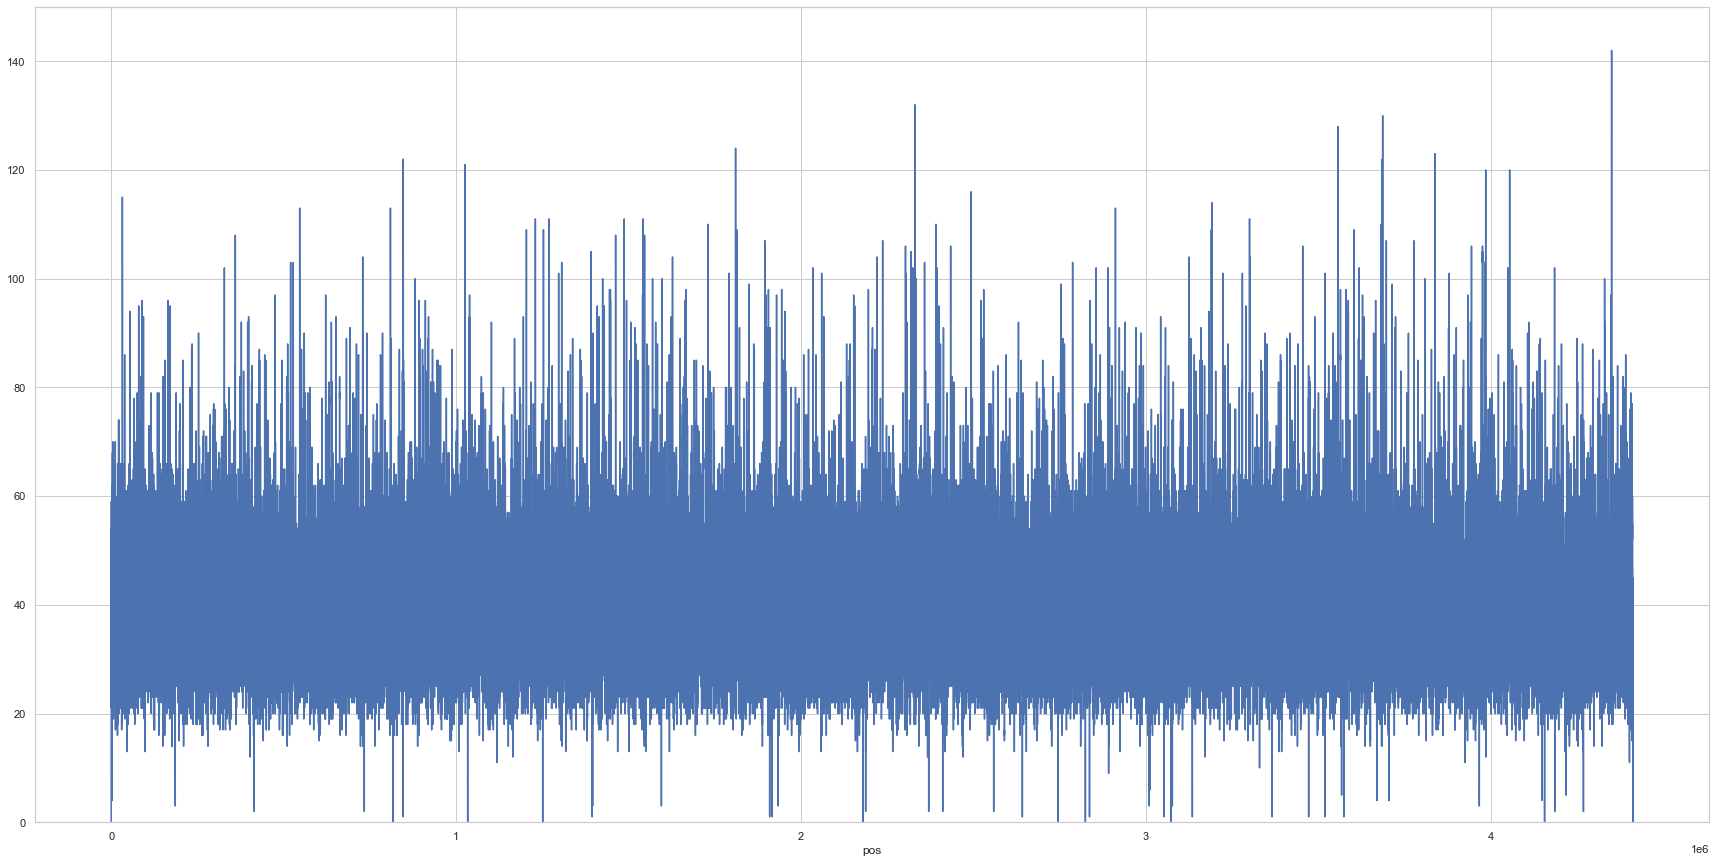

In [143]:
ins1k_perbase_cov.plot(x='pos', y='depth', kind='line', legend=False, figsize=(30,15), ylim=(0,150))

<AxesSubplot:xlabel='pos'>

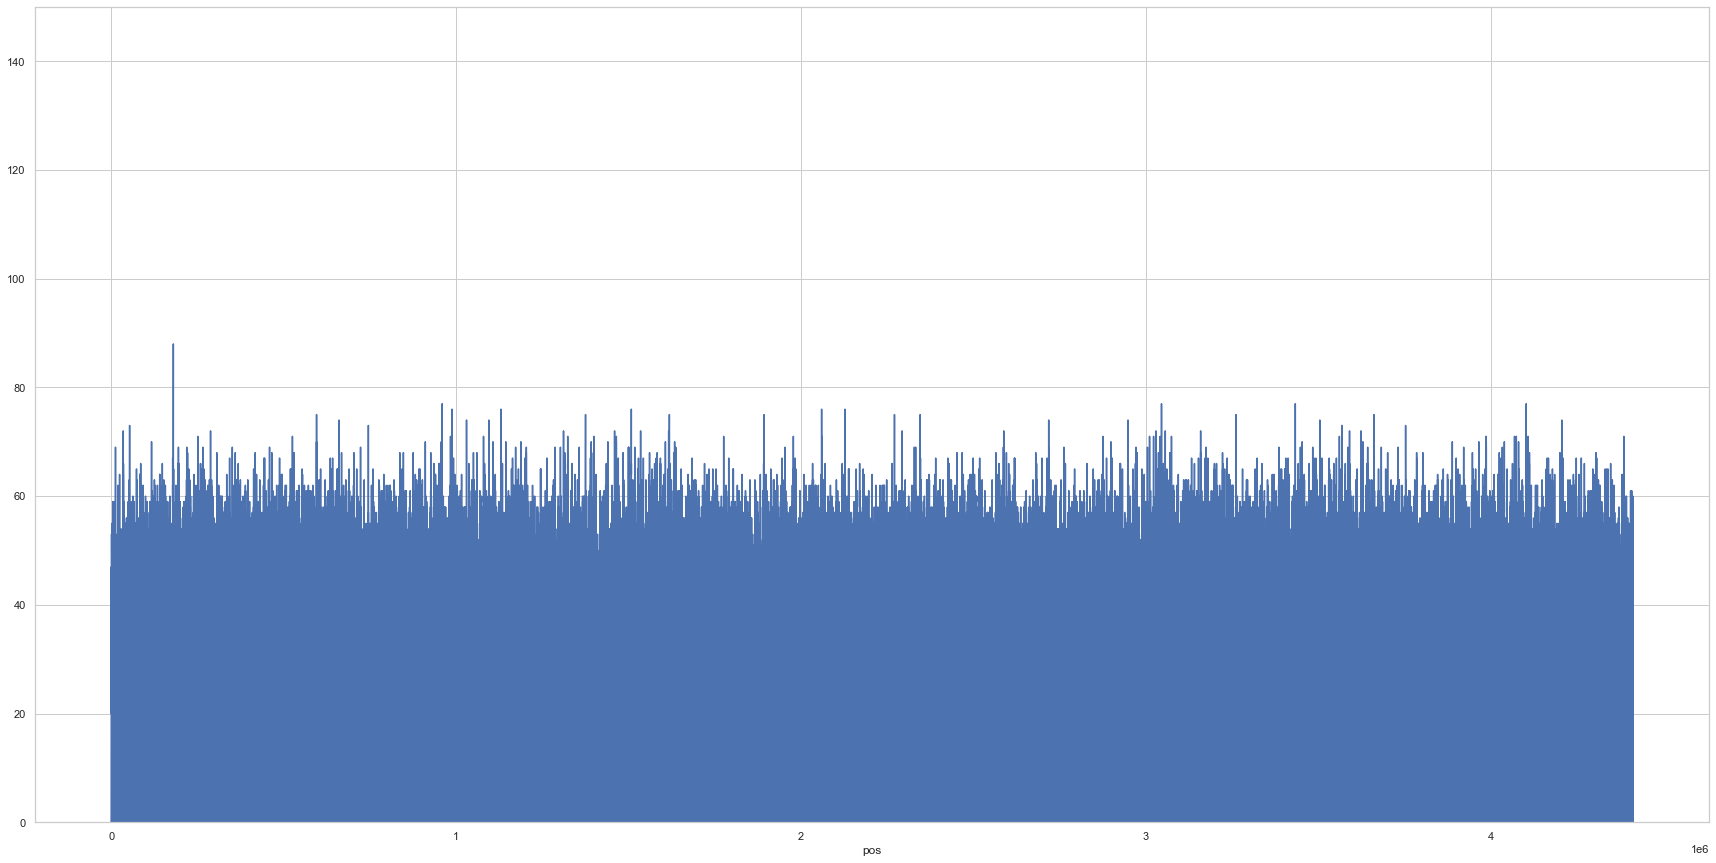

In [147]:
del1k_perbase_cov.plot(x='pos', y='depth', kind='line', legend=False, figsize=(30,15), ylim=(0,150))

In [76]:
# Mapping quality across genomes